## Importação de Bibliotecas

In [1]:
# Bibliotecas:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Balanceamento
from imblearn.over_sampling import SMOTE, ADASYN

# Redução
from sklearn.decomposition import PCA

# Normalização
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Cluster (agrupamento)
from scipy.spatial.distance import cdist 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# Classificação
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict

    # Árvore de decisão
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

    # KNN
from sklearn.neighbors import KNeighborsClassifier

    # SVM
from sklearn.svm import SVC

    # Rede neural (MLP)
from sklearn.neural_network import MLPClassifier

# Seleção e pré-processamento de dados:

* **Base de dados**: ["Loan Data Set"](https://www.kaggle.com/datasets/mirzahasnine/loan-data-set?resource=download);
* **Problema a ser investigado**: Aprovação ou não aprovação de empréstimo para pessoas de acordo com seus dados;
* **Número de amostras**: 614;
* **Número de atributos**: 12;
* **Tipos de atributos**: Categóricos e numéricos;
* **Valores ausentes**: Sim.

### Limpeza de dados

* Leitura da base de dados

In [2]:
def ShowInformationDataFrame(df, message=""):
    print(message+"\n")
    # Imprime as 10 primeiras linhas do arquivo
    print("PRIMEIRAS 10 LINHAS\n")
    print(df.head(10))
    print("\n")
    # Imprime informações sobre os dados
    print("INFORMAÇÕES GERAIS DOS DADOS\n")
    print(df.info())
    print("\n")
    # Imprime uma analise descritiva sobre os dados
    print("DESCRIÇÃO DOS DADOS\n")
    print(df.describe())
    print("\n")
    # Imprime a quantidade de valores faltantes por coluna
    print("VALORES FALTANTES\n")
    print(df.isnull().sum())
    print("\n") 

In [3]:
input_file = './0-Datasets/loan_train.csv'
names = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area', 'Status']
columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area', 'Status']
features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area']
target = 'Status'
df = pd.read_csv(input_file,        # Nome do arquivo com dados
                names = names,      # Nome das colunas 
                usecols = columns, # Define as colunas que serão  utilizadas
                na_values='')       # Define que ? será considerado valores ausentes

ShowInformationDataFrame(df, "DataFrame")

DataFrame

PRIMEIRAS 10 LINHAS

  Gender Married Dependents     Education Self_Employed  Applicant_Income  \
0   Male      No          0  Not Graduate            No            604500   
1   Male      No          0      Graduate            No            584900   
2   Male     Yes          1      Graduate            No            458300   
3   Male     Yes          0      Graduate           Yes            300000   
4   Male     Yes          0  Not Graduate            No            258300   
5   Male      No          0      Graduate            No            600000   
6   Male     Yes          2      Graduate           Yes            541700   
7   Male     Yes          0  Not Graduate            No            233300   
8   Male     Yes         3+      Graduate            No            303600   
9   Male     Yes          2      Graduate            No            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History       Area Status  
0                 0.0     11500000  360.0 

* Tratamento dos valores faltantes
  * método de DELETAR os objetos que possuem valores faltantes

In [4]:
def UpdateMissingValues(df, column, method="mode", number=0):
    if method == 'number':
        # Substituindo valores ausentes por um número
        df[column].fillna(number, inplace=True)
    elif method == 'median':
        # Substituindo valores ausentes pela mediana 
        median = df[column].median()
        df[column].fillna(median, inplace=True)
    elif method == 'mean':
        # Substituindo valores ausentes pela média
        mean = df[column].mean()
        df[column].fillna(mean, inplace=True)
    elif method == 'mode':
        # Substituindo valores ausentes pela moda
        mode = df[column].mode()[0]
        df[column].fillna(mode, inplace=True)
    elif method == 'delete':
        df.dropna(axis=0, how='any', subset=column, inplace=True)

columns_missing_value = df.columns[df.isnull().any()]
print(columns_missing_value)
method = 'delete' # number or median or mean or mode
    
for c in columns_missing_value:
    UpdateMissingValues(df, c, method)
    
ShowInformationDataFrame(df,"Dataframe UpdateMissingValues")

Index(['Gender', 'Married', 'Dependents', 'Self_Employed', 'Term',
       'Credit_History'],
      dtype='object')
Dataframe UpdateMissingValues

PRIMEIRAS 10 LINHAS

  Gender Married Dependents     Education Self_Employed  Applicant_Income  \
0   Male      No          0  Not Graduate            No            604500   
1   Male      No          0      Graduate            No            584900   
2   Male     Yes          1      Graduate            No            458300   
3   Male     Yes          0      Graduate           Yes            300000   
4   Male     Yes          0  Not Graduate            No            258300   
5   Male      No          0      Graduate            No            600000   
6   Male     Yes          2      Graduate           Yes            541700   
7   Male     Yes          0  Not Graduate            No            233300   
8   Male     Yes         3+      Graduate            No            303600   
9   Male     Yes          2      Graduate            No        

* Conversão dos atributos categóricos para numéricos

In [5]:
# Converte os atributos categóricos para numéricos
    # get all categorical columns
cat_columns = df.select_dtypes(['object']).columns

    # convert all categorical columns to numeric
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])

ShowInformationDataFrame(df,"Dataframe numérico")

Dataframe numérico

PRIMEIRAS 10 LINHAS

   Gender  Married  Dependents  Education  Self_Employed  Applicant_Income  \
0       0        0           0          0              0            604500   
1       0        0           0          1              0            584900   
2       0        1           1          1              0            458300   
3       0        1           0          1              1            300000   
4       0        1           0          0              0            258300   
5       0        0           0          1              0            600000   
6       0        1           2          1              1            541700   
7       0        1           0          0              0            233300   
8       0        1           3          1              0            303600   
9       0        1           2          1              0            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History  Area  Status  
0                 0.0     

### Balanceamento de dados

A base se apresentou desbalanceada, dessa forma, foi necessário utilizar uma técnica de balanceamento.

* Técnicas de Oversample:
  * SMOTE (utilizada)
  * ADASYN

Base default
 1    341
0    158
Name: Status, dtype: int64
Base balanceada
 0    341
1    341
Name: Status, dtype: int64


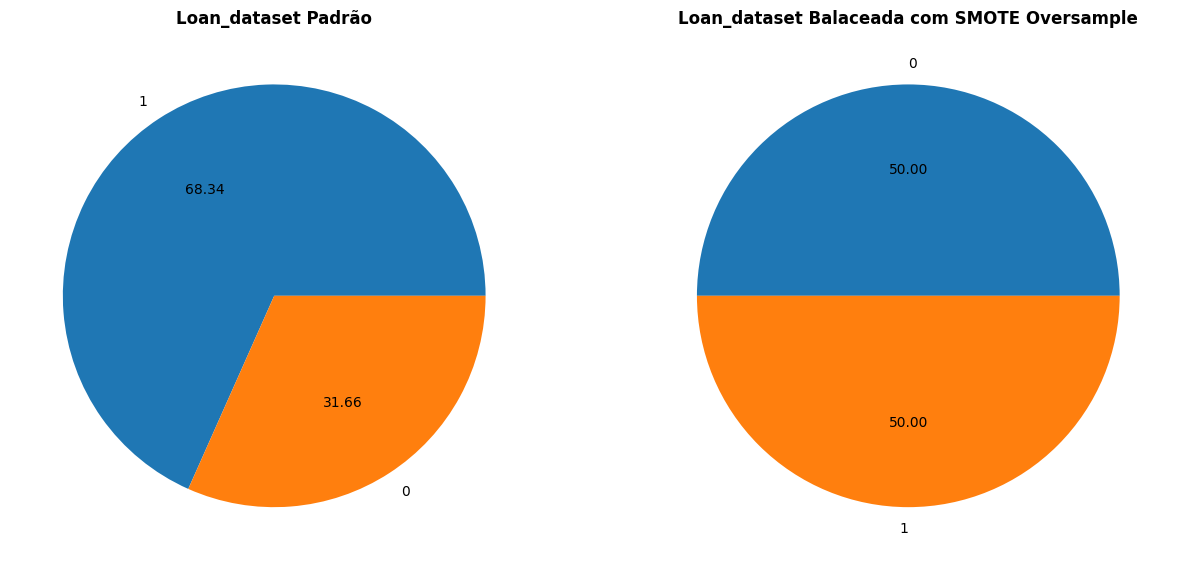

In [6]:
x = df.drop(['Status'], axis=1)
y = df['Status']

# Synthetic Minority Oversampling Technique (SMOTE)
x_os, y_os = SMOTE().fit_resample(x, y)
# Adaptive Synthetic (ADASYN) sampling method
# x_os, y_os = ADASYN().fit_resample(x, y)

print('Base default\n',y.value_counts())
print('Base balanceada\n',y_os.value_counts())

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

y.value_counts().plot.pie(ax=ax[0], autopct='%.2f')
y_os.value_counts().plot.pie(ax=ax[1], autopct='%.2f')

plt.subplots_adjust(hspace = 1)

for n in np.arange(0,2):
    ax[n].set_ylabel('')
    
ax[0].set_title('Loan_dataset Padrão', fontweight='bold')
ax[1].set_title('Loan_dataset Balaceada com SMOTE Oversample', fontweight='bold')

plt.show()

---
# Normalização e redução de dados

### Normalização de dados
* Max-Min
* Z-Score

In [7]:
# Z-score normalization
x_zscore = StandardScaler().fit_transform(x_os)
normalized_zscore_Df = pd.DataFrame(data = x_zscore, columns = features)
normalized_zscore_Df = pd.concat([normalized_zscore_Df, y_os], axis = 1)
ShowInformationDataFrame(normalized_zscore_Df,"Dataframe Z-Score Normalized")

# Mix-Max normalization
x_minmax = MinMaxScaler().fit_transform(x_os)
normalized_minmax_Df = pd.DataFrame(data = x_minmax, columns = features)
normalized_minmax_Df = pd.concat([normalized_minmax_Df, y_os], axis = 1)
ShowInformationDataFrame(normalized_minmax_Df,"Dataframe Min-Max Normalized")

Dataframe Z-Score Normalized

PRIMEIRAS 10 LINHAS

   Gender   Married  Dependents  Education  Self_Employed  Applicant_Income  \
0 -0.4072 -1.187390   -0.738083  -1.657484      -0.356753          0.098324   
1 -0.4072 -1.187390   -0.738083   0.603324      -0.356753          0.064433   
2 -0.4072  0.842184    0.314998   0.603324      -0.356753         -0.154473   
3 -0.4072  0.842184   -0.738083   0.603324       2.803060         -0.428192   
4 -0.4072  0.842184   -0.738083  -1.657484      -0.356753         -0.500296   
5 -0.4072 -1.187390   -0.738083   0.603324      -0.356753          0.090543   
6 -0.4072  0.842184    1.368079   0.603324       2.803060         -0.010265   
7 -0.4072  0.842184   -0.738083  -1.657484      -0.356753         -0.543524   
8 -0.4072  0.842184    2.421160   0.603324      -0.356753         -0.421967   
9 -0.4072  0.842184    1.368079   0.603324      -0.356753         -0.254243   

   Coapplicant_Income  Loan_Amount      Term  Credit_History      Area  Status 

### Redução de dados (PCA)

Explained variance per component:
[0.25012380153585234, 0.20138795310890462, 0.13634736160241834, 0.1228005313814912, 0.09179151136091379, 0.08453872246532346, 0.07023205150267273, 0.01886350461984367, 0.016688017370451405, 0.004663483907549185, 0.002563061144579416]



Dataframe PCA

PRIMEIRAS 10 LINHAS

   principal component 1  principal component 2  Status
0               0.603973               1.123273       0
1               0.540458              -0.206122       1
2              -0.470999              -0.036231       0
3              -0.373700              -0.344649       1
4              -0.376912               0.505186       1
5               0.541097              -0.205298       1
6              -0.596414              -0.357690       1
7              -0.374610               0.507887       1
8              -0.540214              -0.216349       0
9              -0.559413              -0.277659       1


INFORMAÇÕES GERAIS DOS DADOS

<class 'pandas.core.frame.DataFrame'>
RangeIn

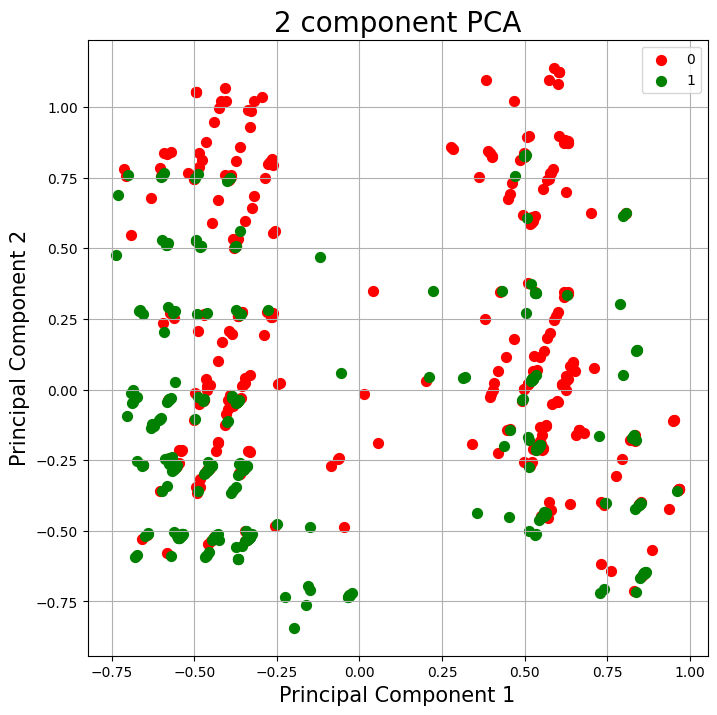

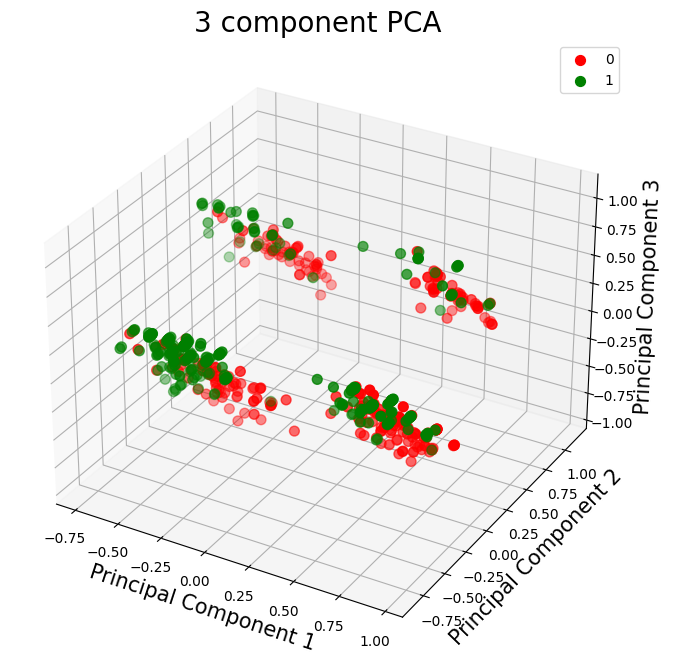

In [45]:
def VisualizePcaProjection(finalDf, targetColumn, tridimensional=False):
    fig = plt.figure(figsize = (8,8))
    
    if tridimensional:
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.set_zlabel('Principal Component 3', fontsize = 15)
        ax.set_title('3 component PCA', fontsize = 20)
    else:
        ax = fig.add_subplot(1,1,1)
        ax.set_title('2 component PCA', fontsize = 20)

    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)   
    
    targets = [ 0, 1 ]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf[targetColumn] == target
        if tridimensional:
            ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                   finalDf.loc[indicesToKeep, 'principal component 2'],
                   finalDf.loc[indicesToKeep, 'principal component 3'],
                   c = color, s = 50)
        else:
            ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                    finalDf.loc[indicesToKeep, 'principal component 2'],
                    c = color, s = 50)
    ax.legend(targets)
    ax.grid()
    plt.show()

# PCA projection
pca = PCA()
# utilizando a normalização Z-Score    
# principalComponents = pca.fit_transform(x_zscore)
# utilizando a normalização Max-Min  
principalComponents = pca.fit_transform(x_minmax)
print("Explained variance per component:")
print(pca.explained_variance_ratio_.tolist())
print("\n\n")

principalDf = pd.DataFrame(data = principalComponents[:,0:2], 
                            columns = ['principal component 1', 
                                        'principal component 2'])
principalDf3d = pd.DataFrame(data = principalComponents[:,0:3], 
                            columns = ['principal component 1', 
                                        'principal component 2',
                                        'principal component 3'])
finalDf = pd.concat([principalDf, y_os], axis = 1)   
finalDf3d = pd.concat([principalDf3d, y_os], axis = 1)  
ShowInformationDataFrame(finalDf,"Dataframe PCA")

VisualizePcaProjection(finalDf, target)
VisualizePcaProjection(finalDf3d, target, tridimensional=True)

---
# Análise descritiva de dados
* Distribuição de frequência
* Visualização de dados (Histograma, Gráfico de setores, dispersão, etc)
* Medidas de resumo
  * Medidas de tendência central
  * Medidas de dispersão
  * Medidas de posição relativa
  * Medidas de associação

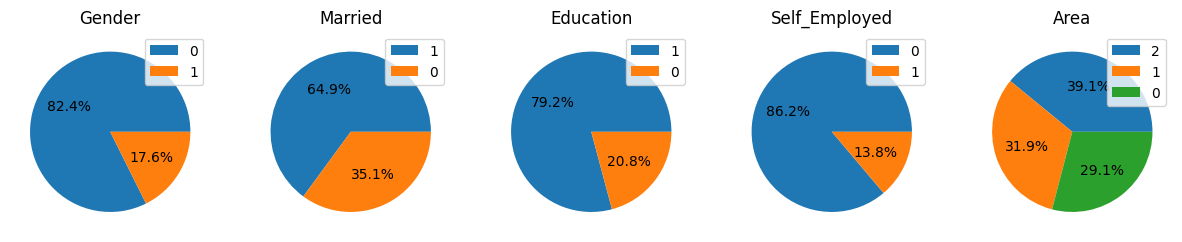

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(15,10))
gender_pie = df['Gender'].value_counts().plot(ax=ax[0],kind='pie', legend=True, title='Gender', autopct='%1.1f%%', labeldistance=None, ylabel='')
married_pie = df['Married'].value_counts().plot(ax=ax[1],kind='pie', legend=True, title='Married', autopct='%1.1f%%', labeldistance=None, ylabel='')
educ_pie = df['Education'].value_counts().plot(ax=ax[2],kind='pie', legend=True, title='Education', autopct='%1.1f%%', labeldistance=None, ylabel='')
selfemp_pie = df['Self_Employed'].value_counts().plot(ax=ax[3],kind='pie', legend=True, title='Self_Employed', autopct='%1.1f%%', labeldistance=None, ylabel='')
area_pie = df['Area'].value_counts().plot(ax=ax[4],kind='pie', legend=True, title='Area', autopct='%1.1f%%', labeldistance=None, ylabel='')

plt.subplots_adjust(hspace = 0.5)

plt.show()

<AxesSubplot:title={'center':'Dependents'}>

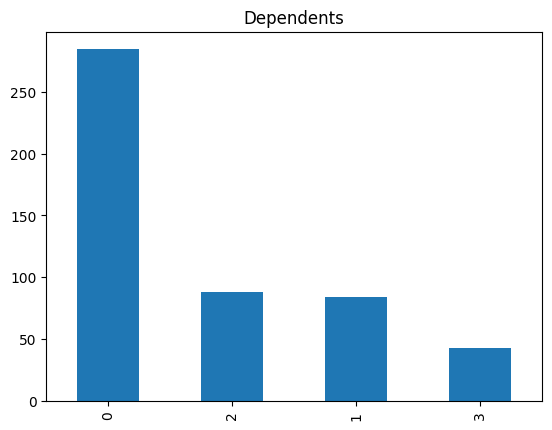

In [10]:
df['Dependents'].value_counts().plot(kind='bar', title='Dependents')

Média = 690312.41
Desvio Padrão = 590802.79
144200.0 8100000.0
0       (600000.0, 800000.0]
1       (400000.0, 600000.0]
2       (600000.0, 800000.0]
3       (200000.0, 400000.0]
4       (400000.0, 600000.0]
               ...          
609     (200000.0, 400000.0]
610     (400000.0, 600000.0]
611    (800000.0, 1000000.0]
612     (600000.0, 800000.0]
613     (400000.0, 600000.0]
Length: 499, dtype: category
Categories (8, interval[float64, right]): [(0.0, 200000.0] < (200000.0, 400000.0] < (400000.0, 600000.0] < (600000.0, 800000.0] < (800000.0, 1000000.0] < (1000000.0, 1200000.0] < (1200000.0, 1400000.0] < (1400000.0, 8100000.0]]


Text(0.5, 1.0, 'Total_Income')

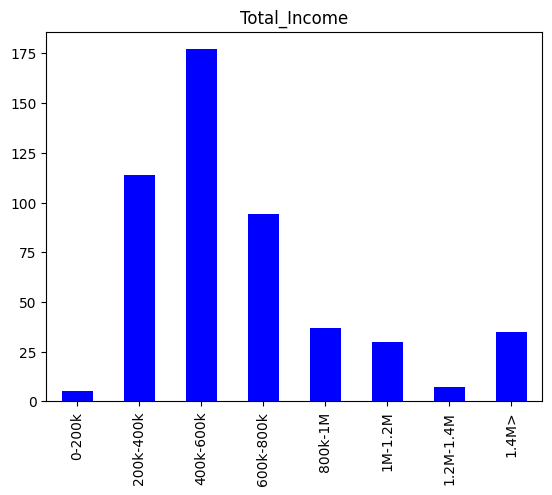

In [11]:
min = (df['Applicant_Income'] + df['Coapplicant_Income']).min()
max = (df['Applicant_Income'] + df['Coapplicant_Income']).max()
mean = (df['Applicant_Income'] + df['Coapplicant_Income']).mean()
std = (df['Applicant_Income'] + df['Coapplicant_Income']).std()
print(f'Média = {mean:.2f}\nDesvio Padrão = {std:.2f}')
print(min, max)
bins = []
for x in range(0, 1600000, 200000):
    bins.append(x)
bins.append(max)

print(pd.cut((df['Applicant_Income'] + df['Coapplicant_Income']), bins))
ax = pd.cut((df['Applicant_Income'] + df['Coapplicant_Income']), bins).value_counts(sort=False).plot.bar(color='blue')
ax.set_xticks(np.arange(8), ['0-200k', '200k-400k', '400k-600k', '600k-800k', '800k-1M', '1M-1.2M', '1.2M-1.4M', '1.4M>'])
ax.set_title('Total_Income')

Média = 13952505.01
Desvio Padrão = 8345237.00
0 60000000
0      (10000000, 12500000]
1      (12500000, 15000000]
2      (12500000, 15000000]
3        (5000000, 7500000]
4      (10000000, 12500000]
               ...         
609      (5000000, 7500000]
610      (2500000, 5000000]
611    (17500000, 60000000]
612    (17500000, 60000000]
613    (12500000, 15000000]
Name: Loan_Amount, Length: 499, dtype: category
Categories (8, interval[int64, right]): [(0, 2500000] < (2500000, 5000000] < (5000000, 7500000] < (7500000, 10000000] < (10000000, 12500000] < (12500000, 15000000] < (15000000, 17500000] < (17500000, 60000000]]


Text(0.5, 1.0, 'Loan_Amount')

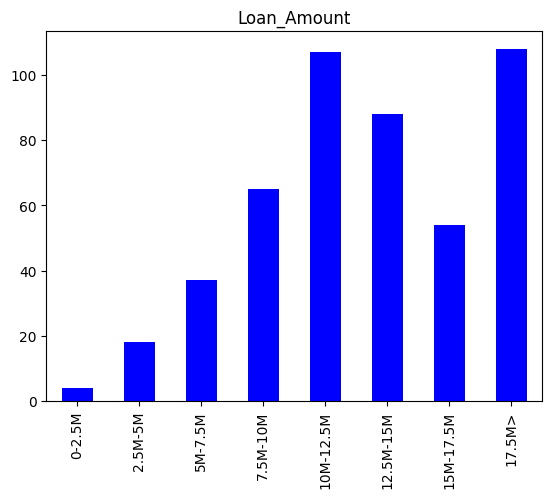

In [31]:
min = df['Loan_Amount'].min()
max = df['Loan_Amount'].max()
mean = df['Loan_Amount'].mean()
std = df['Loan_Amount'].std()
print(f'Média = {mean:.2f}\nDesvio Padrão = {std:.2f}')

print(min, max)
bins = []
# bins.append(0)
for x in range(0, 20000000, 2500000):
    bins.append(x)
bins.append(max)

print(pd.cut(df['Loan_Amount'], bins))
ax = pd.cut(df['Loan_Amount'], bins).value_counts(sort=False).plot.bar(color='blue')
ax.set_xticks(np.arange(8), ['0-2.5M', '2.5M-5M', '5M-7.5M', '7.5M-10M', '10M-12.5M', '12.5M-15M', '15M-17.5M', '17.5M>'])
ax.set_title('Loan_Amount')
# (df['Applicant_Income'] + df['Coapplicant_Income']).plot(kind='hist', title='Total_Income')

<AxesSubplot:title={'center':'Term'}>

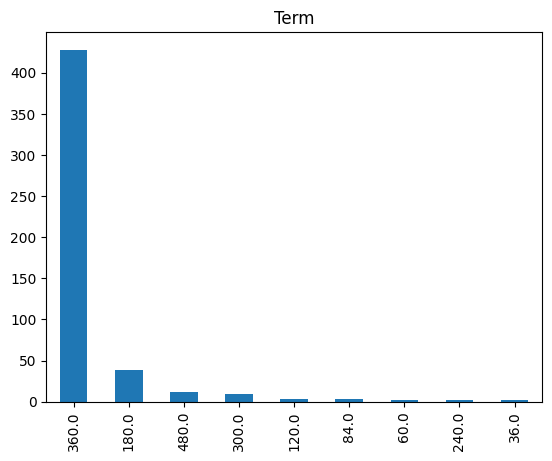

In [13]:
df['Term'].value_counts().plot(kind='bar', title='Term')

<AxesSubplot:>

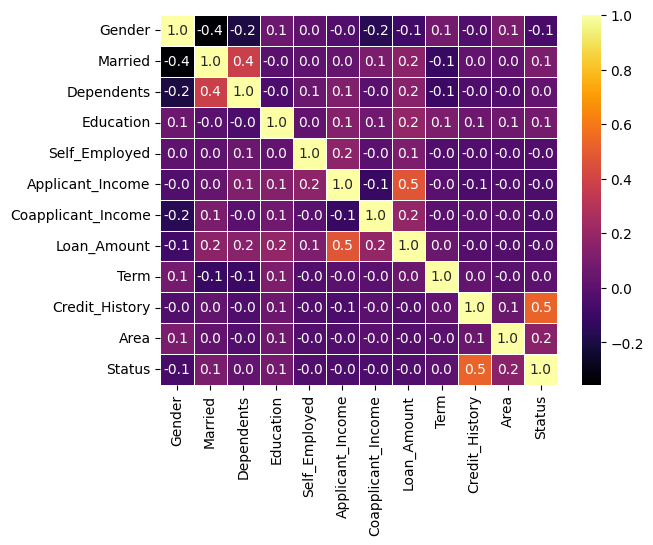

In [39]:
correlation = df.corr()
plot = sns.heatmap(correlation, annot=True, fmt='.1f', linewidths=.6, cmap='inferno')
plot

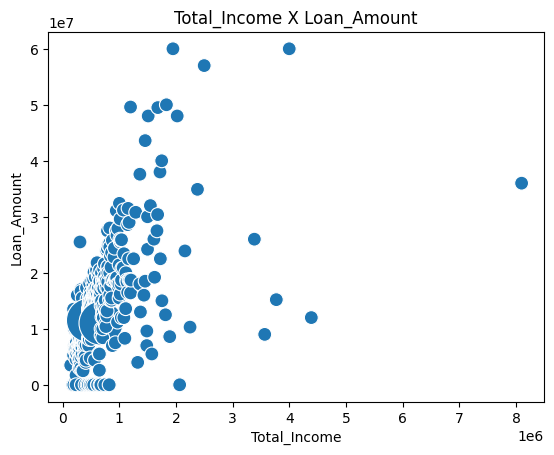

In [14]:
dfTemp = df.copy()
dfTemp['Total_Income'] = df['Applicant_Income'] + df['Coapplicant_Income']
dfTemp['Loan_Amount'] = df['Loan_Amount']

dfTemp_dispersao = dfTemp[['Total_Income', 'Loan_Amount']]
dfTemp_dispersao = dfTemp_dispersao.groupby(['Total_Income', 'Loan_Amount']).size().reset_index(name='tamanho')
fig = plt.figure()

ax = sns.scatterplot(data=dfTemp_dispersao, x='Total_Income', y='Loan_Amount', size='tamanho', legend=False, sizes=(100,1000))
plt.title('Total_Income X Loan_Amount')
plt.show()

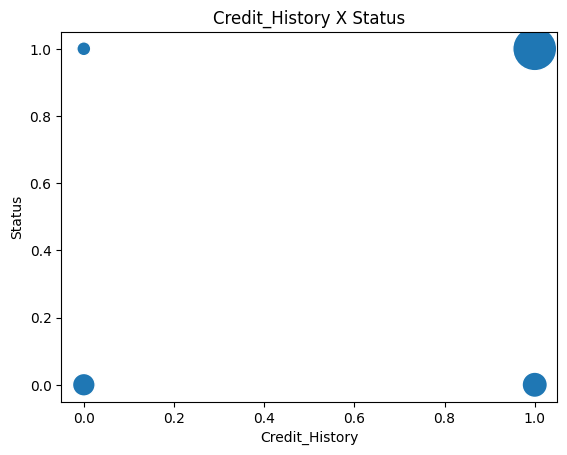

In [41]:
df_dispersao = df[['Credit_History','Status']]

df_dispersao = df_dispersao.groupby(['Credit_History', 'Status']).size().reset_index(name='tamanho')
fig = plt.figure()

ax = sns.scatterplot(data=df_dispersao, x='Credit_History', y='Status', size='tamanho', legend=False, sizes=(100,1000))
plt.title('Credit_History X Status')
plt.show()

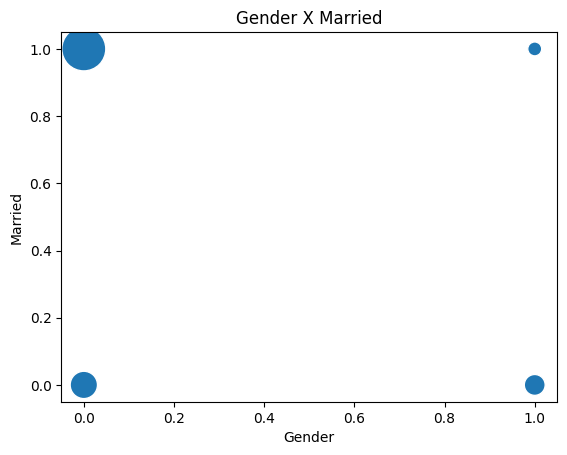

In [40]:
df_dispersao = df[['Gender','Married']]

df_dispersao = df_dispersao.groupby(['Gender', 'Married']).size().reset_index(name='tamanho')
fig = plt.figure()

ax = sns.scatterplot(data=df_dispersao, x='Gender', y='Married', size='tamanho', legend=False, sizes=(100,1000))
plt.title('Gender X Married')
plt.show()


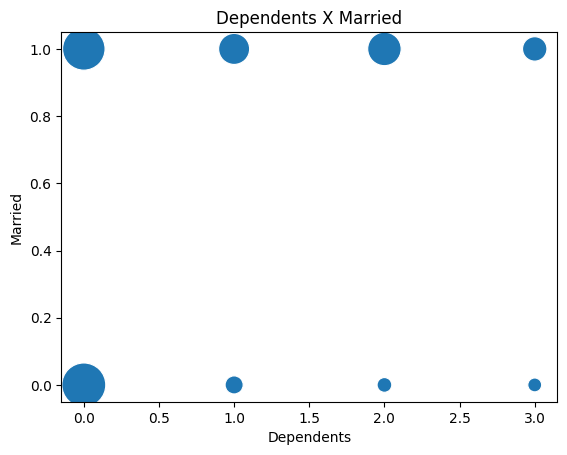

In [43]:
df_dispersao = df[['Dependents','Married']]

df_dispersao = df_dispersao.groupby(['Dependents', 'Married']).size().reset_index(name='tamanho')
fig = plt.figure()

ax = sns.scatterplot(data=df_dispersao, x='Dependents', y='Married', size='tamanho', legend=False, sizes=(100,1000))
plt.title('Dependents X Married')
plt.show()


---
# Análise de grupos

In [16]:
def plot_samples(projected, labels, title):    
    fig = plt.figure()
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(projected[labels == i , 0] , projected[labels == i , 1] , label = i,
                    edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('tab10', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.legend()
    plt.title(title)
    plt.show()

### K-means
* Variar número de grupos (parâmetro k)

##### K-means Sklearn

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


583.900037108857
For n_clusters = 2, silhouette score is 0.2525519517498515)
For n_clusters = 2, homogeinity score is 0.028893988032566924)


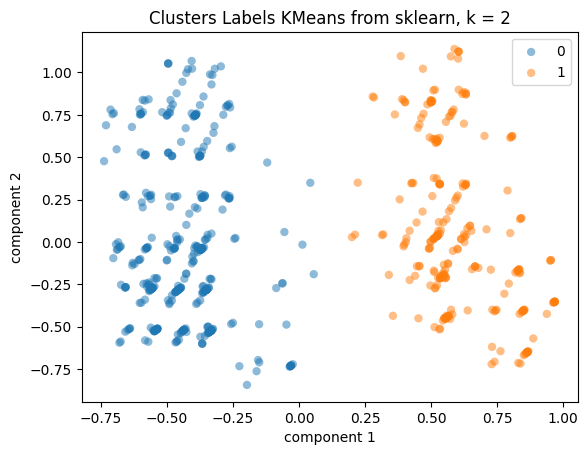

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


490.9640298079611
For n_clusters = 3, silhouette score is 0.26911049770513246)
For n_clusters = 3, homogeinity score is 0.054100252072287434)


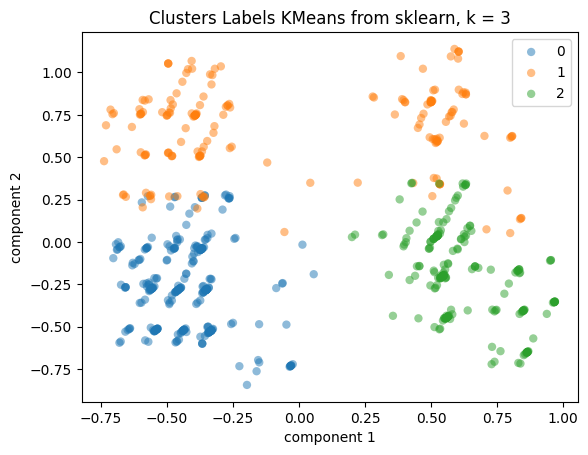

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


436.90189188381396
For n_clusters = 4, silhouette score is 0.2724201194747392)
For n_clusters = 4, homogeinity score is 0.06018354674951595)


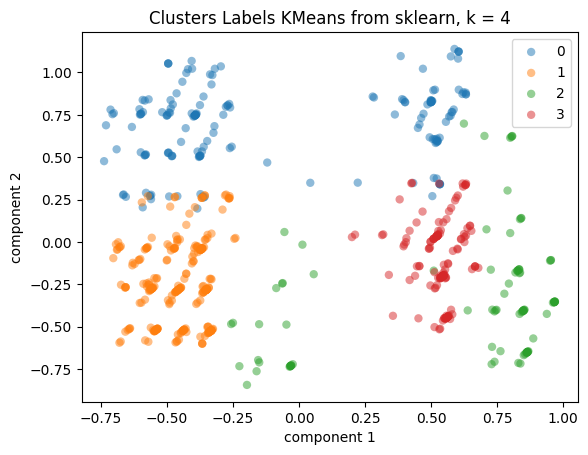

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


393.4361465051905
For n_clusters = 5, silhouette score is 0.2999604622165722)
For n_clusters = 5, homogeinity score is 0.06521754917577409)


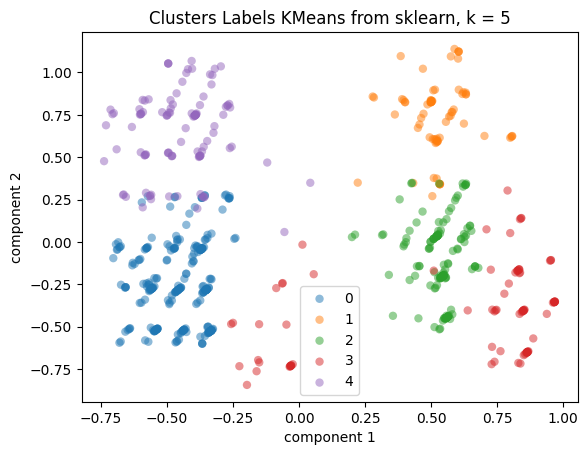

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


358.0849868353626
For n_clusters = 6, silhouette score is 0.3155024323507159)
For n_clusters = 6, homogeinity score is 0.06709881282074474)


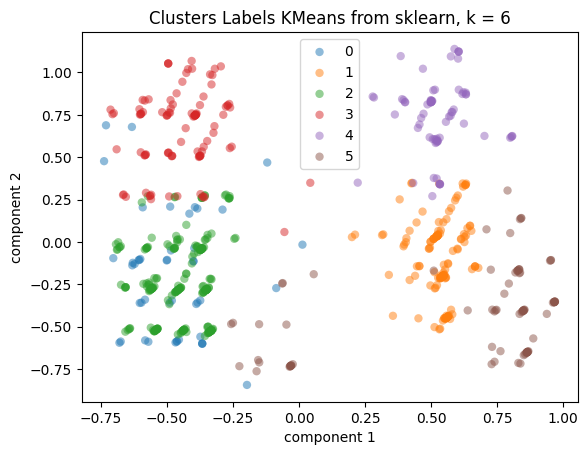

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


330.8998373480888
For n_clusters = 7, silhouette score is 0.3147106009813597)
For n_clusters = 7, homogeinity score is 0.14314810937901778)


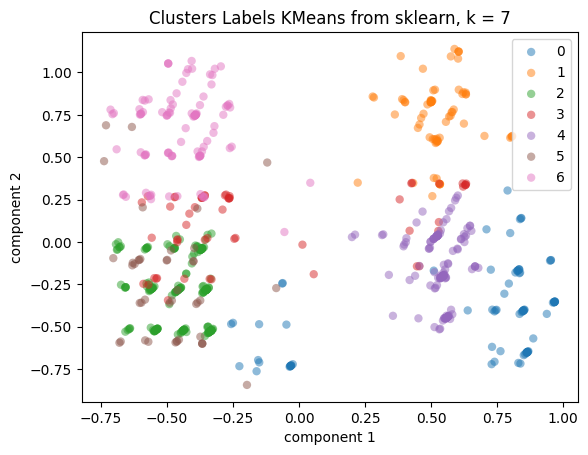

In [17]:
#Applying sklearn kmeans function
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k).fit(principalComponents)
    print(kmeans.inertia_)
    centers = kmeans.cluster_centers_
    score = silhouette_score(principalComponents, kmeans.labels_)    
    print("For n_clusters = {}, silhouette score is {})".format(k, score))
    homogeneity = homogeneity_score(y_os.to_numpy(), kmeans.labels_)
    print("For n_clusters = {}, homogeinity score is {})".format(k, homogeneity))

    #Visualize the results sklearn
    plot_samples(principalComponents, kmeans.labels_, f'Clusters Labels KMeans from sklearn, k = {k}')

#### K-means implementado

For n_clusters = 2, silhouette score is 0.18848063641905777)
For n_clusters = 2, homogeinity score is 0.21139856848003122)


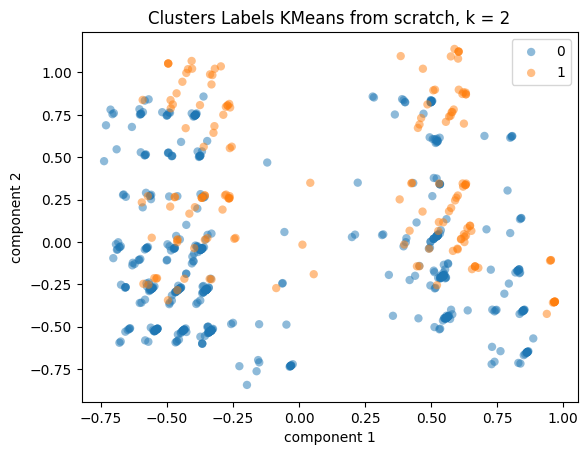

For n_clusters = 3, silhouette score is 0.2590926878171132)
For n_clusters = 3, homogeinity score is 0.03716968335321094)


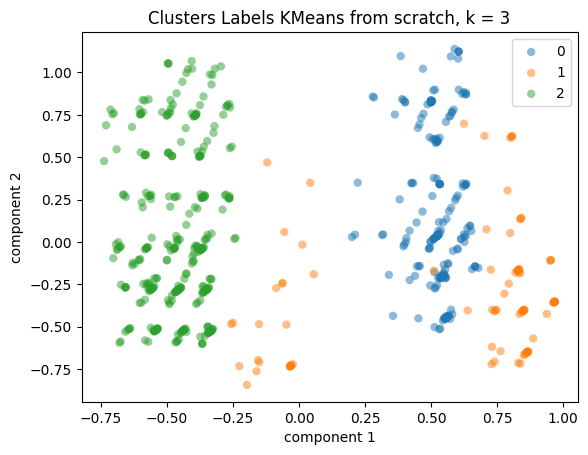

For n_clusters = 4, silhouette score is 0.2387744723441234)
For n_clusters = 4, homogeinity score is 0.19509348629427137)


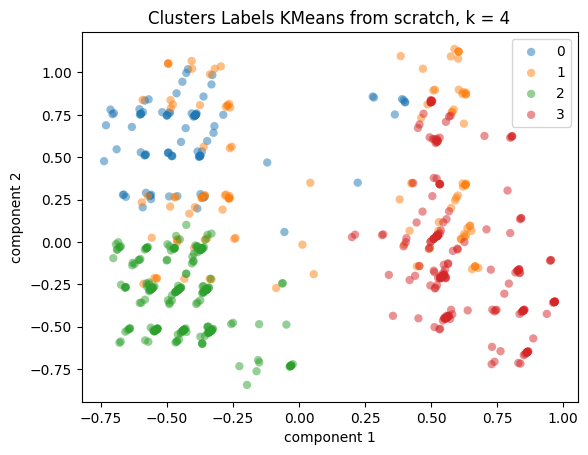

For n_clusters = 5, silhouette score is 0.2598335671194647)
For n_clusters = 5, homogeinity score is 0.09243746767330484)


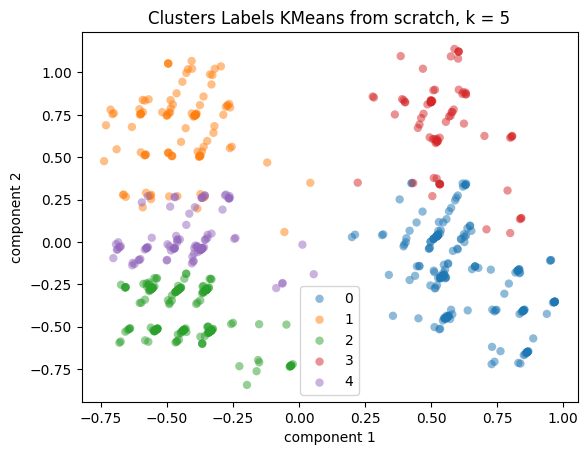

For n_clusters = 6, silhouette score is 0.2741608700825702)
For n_clusters = 6, homogeinity score is 0.14548040297713896)


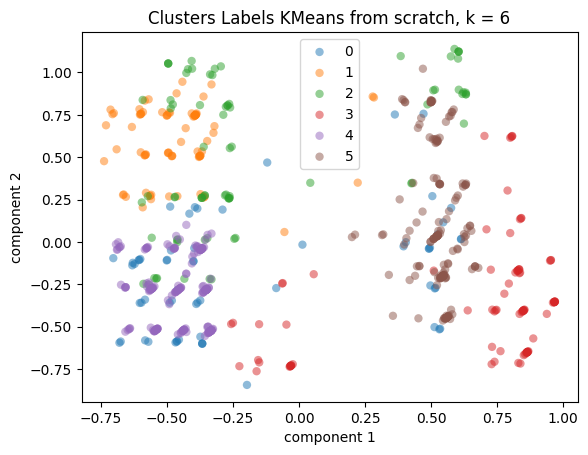

For n_clusters = 7, silhouette score is 0.23859244879122776)
For n_clusters = 7, homogeinity score is 0.1323920992365565)


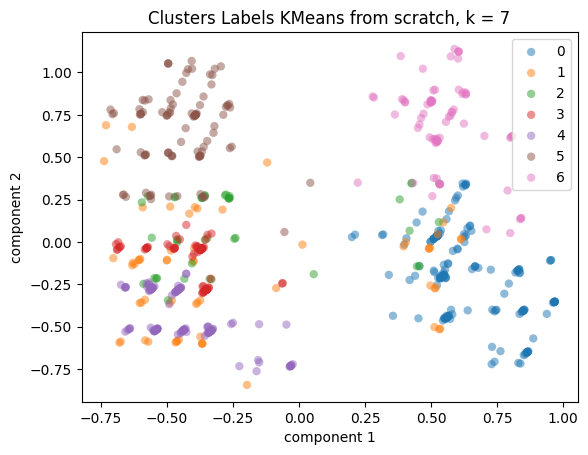

In [18]:
#Defining our kmeans function from scratch
def KMeans_scratch(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
     
    #finding the distance between centroids and all the data points
    distance_type = ('euclidean', 'cityblock', 'minkowski', 'mahalanobis')
    dtype = 2
    distances = cdist(x, centroids ,distance_type[dtype]) #Step 2
    # Euclidean, Cityblock, Minkowski, Mahalanobis
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,distance_type[dtype])
        points = np.array([np.argmin(i) for i in distances])
         
    return points

for k in range(2, 8):
    #Applying our kmeans function from scratch
    labels = KMeans_scratch(principalComponents,k,25)

    score = silhouette_score(principalComponents, labels)    
    print("For n_clusters = {}, silhouette score is {})".format(k, score))
    homogeneity = homogeneity_score(y_os.to_numpy(), labels)
    print("For n_clusters = {}, homogeinity score is {})".format(k, homogeneity))

    #Visualize the results 
    plot_samples(principalComponents, labels, f'Clusters Labels KMeans from scratch, k = {k}')

### GMM

[0.58504399 0.41495601]
[[-4.28377762e-01 -2.99804630e-02  1.05589834e-02  2.21639937e-02
   1.47075878e-02  4.88474568e-02 -4.00744455e-02 -2.44265490e-04
  -1.04703504e-03 -1.40959088e-04  1.29245630e-05]
 [ 6.03967234e-01  4.22692747e-02 -1.48870473e-02 -3.12488816e-02
  -2.07361397e-02 -6.88697359e-02  5.65007200e-02  3.44388447e-04
   1.47620841e-03  1.98737372e-04 -1.82222637e-05]]
For k = 2
Silhouette score is 0.2525519517498515
Homogeinity score is 0.028893988032566924


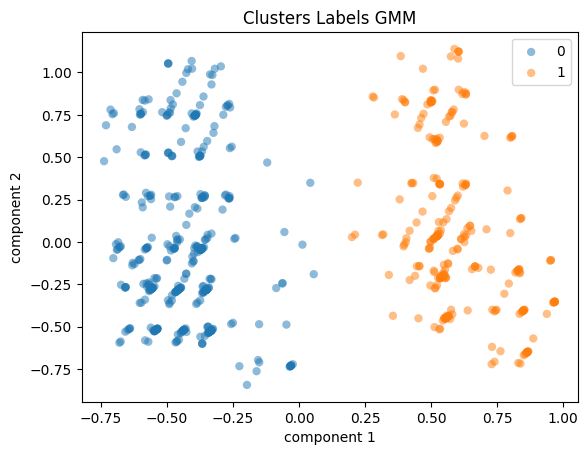

[0.43108504 0.30205279 0.26686217]
[[-4.20231940e-01 -2.71798480e-01 -1.08098228e-01  1.18815685e-02
  -3.77200511e-03  3.84914969e-02 -3.63800207e-02 -2.35616858e-03
  -6.60738214e-04 -1.65927641e-03  1.03289135e-04]
 [ 6.24152406e-01 -2.00707219e-01 -1.45614629e-01 -2.10609543e-02
  -3.83547519e-02 -4.95497879e-02  5.95947993e-02 -4.65874350e-03
  -2.60953371e-04  2.31159412e-03 -2.28812128e-04]
 [-2.76220072e-02  6.66233188e-01  3.39436773e-01  4.64492002e-03
   4.95057604e-02 -6.09474597e-03 -8.68572842e-03  9.07920178e-03
   1.36271115e-03  6.39498652e-05  9.21334753e-05]]
For k = 3
Silhouette score is 0.26911049770513246
Homogeinity score is 0.054100252072287434


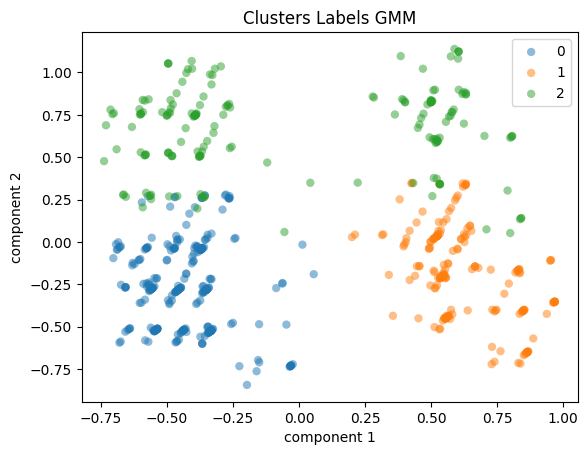

[0.43835772 0.23791442 0.17557532 0.14815255]
[[-4.43925140e-01 -1.48575177e-01  9.53902326e-02 -1.11867277e-01
   6.26374540e-03  2.64810850e-02 -1.79013746e-02 -3.80125068e-03
  -5.98848447e-03  1.91768046e-03 -5.22423738e-03]
 [ 6.46383112e-01 -2.18092434e-01 -1.27089414e-01 -4.25462949e-02
  -2.55378032e-02 -3.13923952e-02  1.54387880e-02  3.52003237e-03
  -4.05538713e-03  4.47581863e-04 -2.95908292e-04]
 [ 5.48354191e-01  3.93328449e-01  1.43880106e-01 -1.82554253e-02
  -1.38278605e-02 -1.19238947e-01  1.07822733e-01 -7.19751720e-03
   6.79655682e-03  3.13571860e-03 -3.70050247e-03]
 [-3.74366244e-01  3.23704480e-01 -2.48665558e-01  4.20954378e-01
   3.88645459e-02  1.13369172e-01 -9.96062193e-02  1.41242761e-02
   1.61767441e-02 -1.01089791e-02  2.03182637e-02]]
For k = 4
Silhouette score is 0.18446695950614755
Homogeinity score is 0.22711117205387119


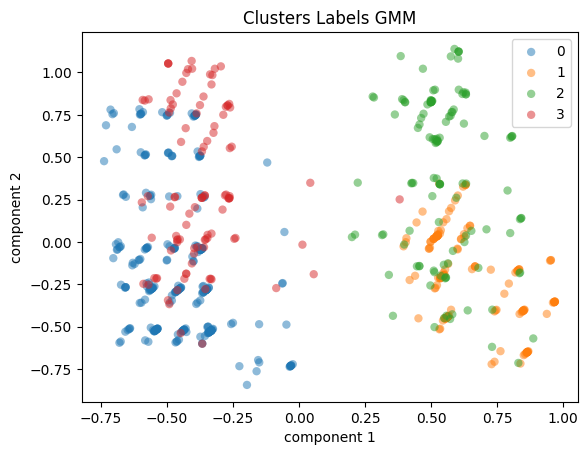

[0.24486804 0.13047484 0.26835214 0.14222874 0.21407625]
[[-8.53359401e-02  6.92948842e-01  3.12396132e-01  8.90492804e-03
  -1.72263906e-03 -4.26726508e-02 -1.01335607e-02  3.11294975e-03
   2.98318806e-03  4.34949888e-04 -1.32400347e-03]
 [-4.45240920e-01  2.27753525e-02 -5.08591832e-01 -1.82314229e-01
   5.54652692e-02  1.09052387e-01 -6.63125209e-02 -1.06910626e-02
   3.65509091e-03  2.09716842e-03  4.15570708e-03]
 [-4.47744411e-01 -3.79502409e-01  4.85655831e-02  9.14065018e-02
  -8.65434486e-02 -7.16028905e-02 -1.32588224e-02 -1.55102294e-03
  -6.74315981e-03 -3.84750941e-03 -1.32931210e-03]
 [ 5.97292285e-01 -3.28878189e-01  2.01740056e-01  6.29295254e-02
   3.98218948e-01  4.80184500e-01  3.88480513e-02  2.93098706e-03
   4.17319541e-03  7.32239566e-04  2.94584048e-04]
 [ 5.33407260e-01 -1.12279711e-01 -2.42265552e-01 -5.54598161e-02
  -1.87919318e-01 -2.46924508e-01  4.28175704e-02  2.95223106e-03
   4.02110163e-05  2.56081108e-03  4.52251634e-04]]
For k = 5
Silhouette score 

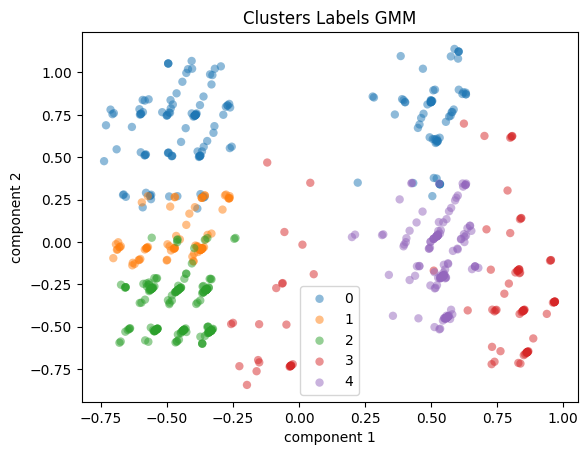

[0.01466091 0.25496499 0.21847618 0.19647983 0.15395894 0.16145914]
[[-3.33528622e-01 -7.26604354e-02 -5.43448479e-01  5.26343450e-02
   4.49813179e-01  1.33222663e-01 -2.03506394e-01  3.26513901e-01
   1.99549835e-01  4.34340566e-02 -1.87695854e-02]
 [-4.04756233e-01 -3.54004517e-01  2.93251729e-02 -8.18577129e-02
  -1.11872265e-01  1.11916366e-01 -2.44890624e-02  5.23179204e-03
  -3.96513719e-02  8.78822482e-04 -9.45726755e-03]
 [ 5.93955871e-01  3.40620178e-01 -4.25653780e-03  1.51573494e-01
  -1.81095408e-02 -9.99717506e-02  3.74255348e-02  4.83407326e-03
   3.04989599e-03 -8.93374703e-03 -9.11760152e-04]
 [ 6.15099392e-01 -2.89482683e-01 -2.67076662e-02 -2.34538632e-01
  -2.36567923e-02 -3.42857808e-02  7.77114151e-02 -4.64792667e-03
  -2.73657023e-04  1.03536239e-02  9.75349198e-04]
 [-4.51186065e-01  6.47109983e-01  3.42799176e-01  5.09547842e-02
   6.64504480e-02  7.78441446e-02 -5.04188350e-02  5.66906317e-03
  -2.12866615e-03  4.11032940e-03 -2.40096240e-04]
 [-4.52542983e-01

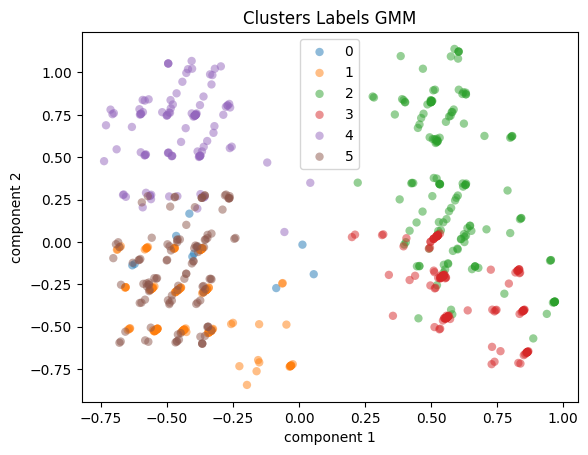

[0.06910465 0.21407625 0.02199413 0.14956012 0.3619804  0.08797654
 0.09530792]
[[-2.89768228e-01 -3.78540078e-01  2.70740296e-02  3.53298378e-02
   1.85491336e-01  3.15231428e-01 -5.31226897e-02 -1.38242147e-01
   1.39771472e-01 -5.90423196e-03 -1.77654079e-03]
 [ 5.33407260e-01 -1.12279711e-01 -2.42265552e-01 -5.54598161e-02
  -1.87919318e-01 -2.46924508e-01  4.28175704e-02  2.95223106e-03
   4.02110163e-05  2.56081108e-03  4.52251634e-04]
 [ 6.14926446e-01  3.68798908e-01  6.40489249e-01 -4.27831693e-02
   6.19848608e-01  4.01139261e-01  7.43347100e-03  7.55034743e-02
  -1.66785984e-02 -4.06651705e-03  1.58584581e-02]
 [-4.63152204e-01  6.57545762e-01  3.33204980e-01  4.50366586e-02
   4.77985233e-02  6.26293036e-02 -4.09298123e-02  2.38276918e-03
  -2.18341051e-03  3.45492715e-03 -3.86403303e-04]
 [-4.45138396e-01 -2.51420745e-01 -1.33903579e-01  7.40512621e-03
  -3.99037307e-02 -1.43401355e-02 -3.31837254e-02  2.35854367e-02
  -2.74702516e-02 -8.48884026e-04  4.62162115e-04]
 [ 8.

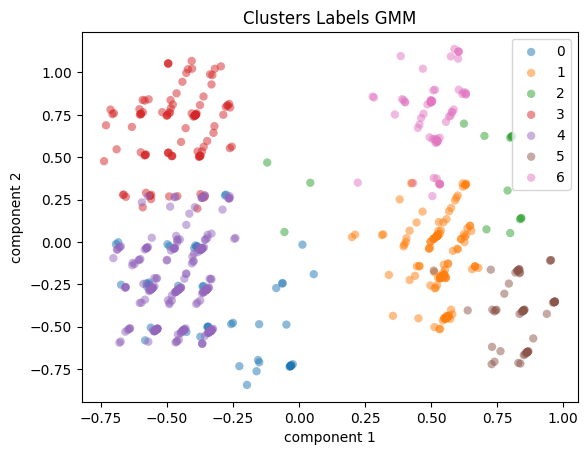

In [19]:
for k in range(2, 8):
    #Applying sklearn GMM function
    gm  = GaussianMixture(n_components=k).fit(principalComponents)
    print(gm.weights_)
    print(gm.means_)
    gm_predicts = gm.predict(principalComponents)
    silhouette_gm_score = silhouette_score(principalComponents, gm_predicts)
    homogeneity_gm_score = homogeneity_score(y_os.to_numpy(), gm_predicts)
    print("For k =", k)
    print("Silhouette score is {}".format(silhouette_gm_score))
    homogeneity = homogeneity_score(y_os.to_numpy(), kmeans.labels_)
    print("Homogeinity score is {}".format(homogeneity_gm_score))
    #Visualize the results sklearn
    plot_samples(principalComponents, gm_predicts, 'Clusters Labels GMM')

---
# Classificação
* Divisão da base:
  * Holdout (Treinamento 70% e Teste 30%)
  * Cross-Validation (k=10)
* Métricas:
  * Matrix de confusão
  * Acurácia
  * F1 Score

In [20]:
x_use = x_zscore # ou x_minmax ou x_zscore ou principalComponents
y_use = y_os

# Separação de conjunto de treinamento (70%) e teste (30%)
x_train, x_test, y_train, y_test = train_test_split(x_use, y_use, test_size=0.3, random_state=0)
print(x_train.shape)
print(x_test.shape)

acuracia_holdout = dict()
f1_holdout = dict()
acuracia_crossval = dict()
f1_crossval = dict()

(477, 11)
(205, 11)


### Árvore de Decisão (Decision Tree)

* Holdout

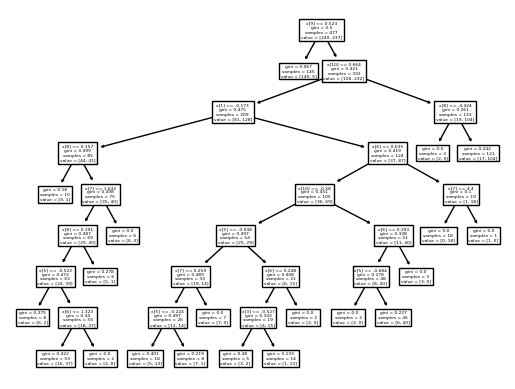

accuracy_score = 80.00%
f1_score = 82.10%


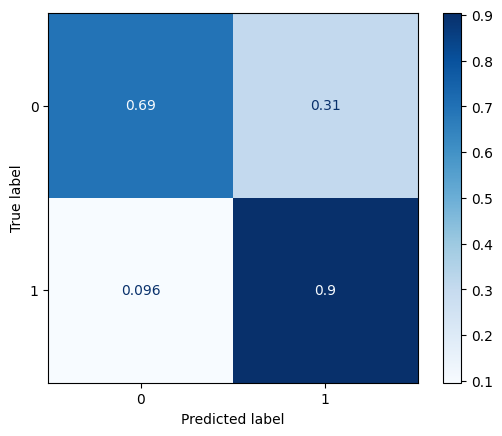

In [83]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Construindo a Árvore de decisão
clf = DecisionTreeClassifier(max_leaf_nodes=20)
clf.fit(x_train, y_train)
tree.plot_tree(clf)
plt.show()

predictions = clf.predict(x_test)
# print(predictions)

# Métricas
accuracy = accuracy_score(y_test, predictions)
f1_score = f1_score(y_test, predictions)
confusion_matrix = confusion_matrix(y_test, predictions, normalize='true')
print('accuracy_score = {:.2f}%'.format(accuracy*100) )
print('f1_score = {:.2f}%'.format(f1_score*100) )
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['DecisionTree'] = accuracy
f1_holdout['DecisionTree'] = f1_score

* Cross-Validation

accuracy_score = 78.48%
f1_score = 79.23%


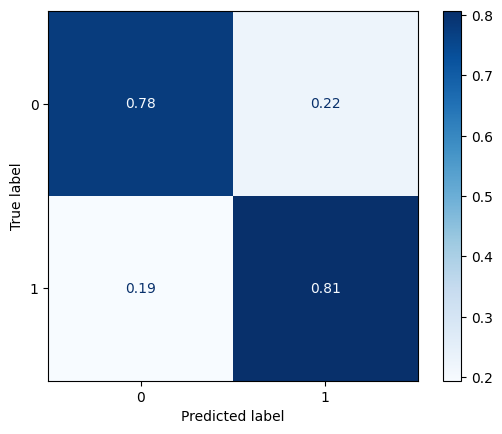

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Validação-cruzada
clf = DecisionTreeClassifier(max_leaf_nodes=50)
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
# print(predictions)

# Métricas
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
print('accuracy_score = {:.2f}%'.format(accuracy*100) )
print('f1_score = {:.2f}%'.format(f1_score*100) )
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['DecisionTree'] = accuracy
f1_crossval['DecisionTree'] = f1_score

### KNN (K-Nearest Neighbors)
* Encontrar o parâmetro k com melhor resultado

* Holdout

Best K: 16
Best Accuracy: 0.7804878048780488
Acurracy K-NN: 78.05%
F1 Score K-NN: 79.82%


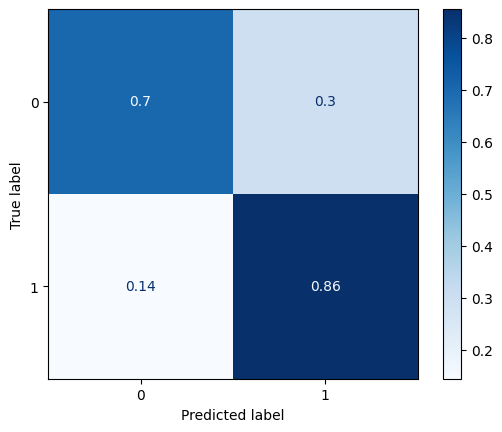

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_k = 0
best_accuracy = 0
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_hat_test = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_hat_test)
    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print(f'Best K: {best_k}\nBest Accuracy: {best_accuracy}')

# TESTS USING knn classifier from sk-learn
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)
y_hat_test = knn.predict(x_test)

# Get test accuracy and F1 score
accuracy = accuracy_score(y_test, y_hat_test)
f1_score = f1_score(y_test, y_hat_test)
print("Acurracy K-NN: {:.2f}%".format(accuracy * 100))
print("F1 Score K-NN: {:.2f}%".format(f1_score * 100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_test, y_hat_test, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['KNN'] = accuracy
f1_holdout['KNN'] = f1_score

* Cross-Validation

Best K: 3
Best Accuracy: 0.7874467178175618
accuracy_score = 78.74%
f1_score = 79.70%


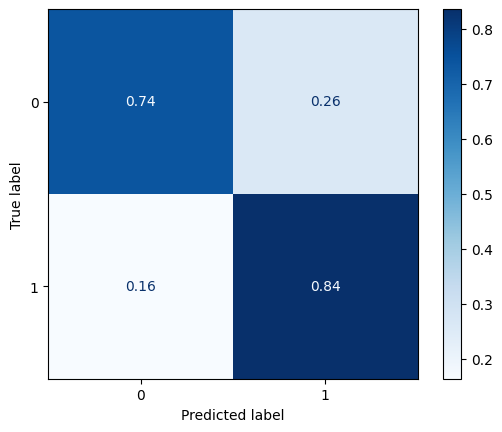

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


best_k = 0
best_accuracy = 0
for k in range(1, 50):
    clf = KNeighborsClassifier(n_neighbors=k)
    result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)
    accuracy = result['test_accuracy'].mean()
    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print(f'Best K: {best_k}\nBest Accuracy: {best_accuracy}')

# Validação-cruzada
clf = KNeighborsClassifier(n_neighbors=best_k)
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
#print(predictions)

# Métricas
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
print('accuracy_score = {:.2f}%'.format(accuracy*100) )
print('f1_score = {:.2f}%'.format(f1_score*100) )
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['KNN'] = accuracy
f1_crossval['KNN'] = f1_score

### SVM (Support Vectors Machine)

* Holdout

Qtd Support vectors: 
[140 147]
Acurracy SVM from sk-learn: 77.07%
F1 Score SVM from sk-learn: 79.65%


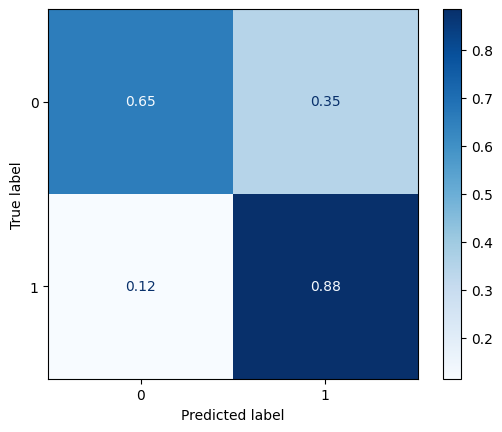

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

 # TESTS USING SVM classifier from sk-learn    
svm = SVC(kernel='linear') # poly, rbf, linear
# training using train dataset
svm.fit(x_train, y_train)
# get support vectors
# print(svm.support_vectors_)
# get indices of support vectors
# print(svm.support_)
# get number of support vectors for each class
print("Qtd Support vectors: ")
print(svm.n_support_)
# predict using test dataset
y_hat_test = svm.predict(x_test)

# Get test accuracy score
accuracy = accuracy_score(y_test, y_hat_test)
f1_score = f1_score(y_test, y_hat_test)
print("Acurracy SVM from sk-learn: {:.2f}%".format(accuracy*100))
print("F1 Score SVM from sk-learn: {:.2f}%".format(f1_score*100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_test, y_hat_test, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['SVM'] = accuracy
f1_holdout['SVM'] = f1_score

* Cross-Validation

accuracy_score = 76.56%
f1_score = 78.81%


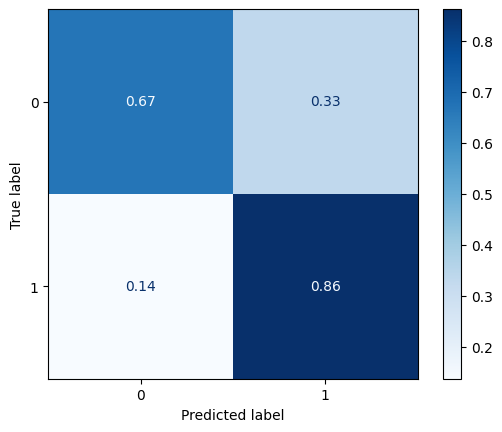

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Validação-cruzada
clf = SVC(kernel='linear') # poly, rbf, linear
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
# print(predictions)

# Métricas
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
print('accuracy_score = {:.2f}%'.format(accuracy*100) )
print('f1_score = {:.2f}%'.format(f1_score*100) )
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['SVM'] = accuracy
f1_crossval['SVM'] = f1_score

### Rede Neural MLP (Multilayer Perceptron)
* Arquitetura da rede:
  * Número de neurônios
  * Camadas escondidas
  * Tipo de função de ativação

* Holdout

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


Acurracy MLP from sk-learn: 74.15%
F1 Score MLP from sk-learn: 76.02%


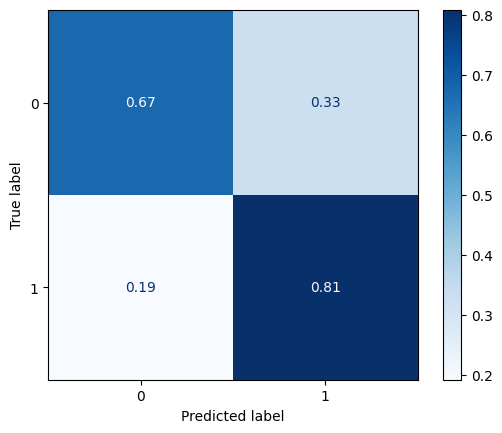

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

mlp = MLPClassifier(hidden_layer_sizes=(10,10),
                    activation='relu',
                    max_iter=1500)
mlp.fit(x_train, y_train)
predictions = mlp.predict(x_test)
# print(predictions)

# Get test accuracy score
accuracy = accuracy_score(y_test, predictions)
f1_score = f1_score(y_test, predictions)
print("Acurracy MLP from sk-learn: {:.2f}%".format(accuracy*100))
print("F1 Score MLP from sk-learn: {:.2f}%".format(f1_score*100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_test, predictions, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['MLP'] = accuracy
f1_holdout['MLP'] = f1_score

* Cross-Validation

Acurracy MLP from sk-learn: 77.29%
F1 Score MLP from sk-learn: 78.57%


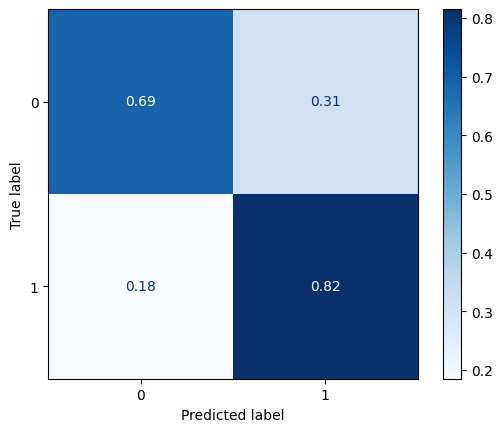

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

clf = MLPClassifier(hidden_layer_sizes=(10,10),
                    activation='relu',
                    max_iter=1500)
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
# print(predictions)
# Get test accuracy score
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
print("Acurracy MLP from sk-learn: {:.2f}%".format(accuracy*100))
print("F1 Score MLP from sk-learn: {:.2f}%".format(f1_score*100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['MLP'] = accuracy
f1_crossval['MLP'] = f1_score

### Comparação final dos classificadores

In [84]:
tree_metrics_holdout = pd.Series({'Classificador': 'DecisionTree', 'accuracy': acuracia_holdout['DecisionTree'], 'f1_score': f1_holdout['DecisionTree']})
knn_metrics_holdout = pd.Series({'Classificador': 'KNN', 'accuracy': acuracia_holdout['KNN'], 'f1_score': f1_holdout['KNN']})
svm_metrics_holdout = pd.Series({'Classificador': 'SVM', 'accuracy': acuracia_holdout['SVM'], 'f1_score': f1_holdout['SVM']})
mlp_metrics_holdout = pd.Series({'Classificador': 'MLP', 'accuracy': acuracia_holdout['MLP'], 'f1_score': f1_holdout['MLP']})

tree_metrics_cross_val = pd.Series({'Classificador': 'DecisionTree', 'accuracy': acuracia_crossval['DecisionTree'], 'f1_score': f1_crossval['DecisionTree']})
knn_metrics_cross_val = pd.Series({'Classificador': 'KNN', 'accuracy': acuracia_crossval['KNN'], 'f1_score': f1_crossval['KNN']})
svm_metrics_cross_val = pd.Series({'Classificador': 'SVM', 'accuracy': acuracia_crossval['SVM'], 'f1_score': f1_crossval['SVM']})
mlp_metrics_cross_val = pd.Series({'Classificador': 'MLP', 'accuracy': acuracia_crossval['MLP'], 'f1_score': f1_crossval['MLP']})

df_metrics_holdout = pd.DataFrame([tree_metrics_holdout, knn_metrics_holdout, svm_metrics_holdout, mlp_metrics_holdout])
df_metrics_cross_val = pd.DataFrame([tree_metrics_cross_val, knn_metrics_cross_val, svm_metrics_cross_val, mlp_metrics_cross_val])

print('\nHOLDOUT\n', df_metrics_holdout.head())
print('\nCROSS-VALIDATION\n', df_metrics_cross_val.head())


HOLDOUT
   Classificador  accuracy  f1_score
0  DecisionTree  0.800000  0.820961
1           KNN  0.780488  0.798206
2           SVM  0.770732  0.796537
3           MLP  0.741463  0.760181

CROSS-VALIDATION
   Classificador  accuracy  f1_score
0  DecisionTree  0.784825  0.792349
1           KNN  0.787447  0.796974
2           SVM  0.765622  0.788067
3           MLP  0.772890  0.785681
